In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim
from torchvision.models import resnet18
import torch
from tqdm import tqdm

torch.manual_seed(0)

## download CIFAR-10

In [2]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18


batch_size = 64
train_data = CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )
test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validate(model, testloader, criterion, device):
    model.eval()
    print("Validation")
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100.0 * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
from torchvision.models import ResNet18_Weights

class ClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Linear(in_features=512, out_features=10, bias=True)
    
    def forward(self, x):
        return self.classifier(x)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [5]:
path = 'data/weights_1.pt'

model = resnet18().to(device)
model.fc = ClassifierHead().to(device)
model.load_state_dict(torch.load(path))
model.eval();

/tmp/ipykernel_449911/2698396606.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [6]:
validate(model, test_dataloader, criterion, device)

Validation


100%|██████████| 157/157 [00:01<00:00, 96.59it/s] 


(1.1781141660205878, 82.37)

### Тестируем атаку

Попробуем провести атаку на нашу исходную модель $f(x) = \text{model}(x)$, а также на Randomized Smoothing Monte-Carlo Estimation $g(x) = \frac{1}{N} \sum \limits_{i = 1}^N f(x + \varepsilon_i)$

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [8]:
from torchvision.transforms.v2 import GaussianNoise

class GHatDetermined(nn.Module):
    '''
    GHat model with fixed values epsilon[i], i = 1...N
    '''
    def __init__(self, model, sigma=0.1, n_samples=100):
        super().__init__()

        self.n_samples = n_samples
        self.noiser = GaussianNoise(mean=0, sigma=sigma)
        self.model = model.to(device)
        self.epsilons = [
            self.noiser(torch.zeros(3, 32, 32)).to(device)
            for _ in range(self.n_samples)
        ]
        self.softmax = nn.Softmax()

    def forward(self, x):
        probs = torch.zeros(1, 10).to(device)
        probs.requires_grad = True
        for i in range(self.n_samples):
            new_x = x + self.epsilons[i]
            probs = probs + self.softmax(self.model(new_x))
        probs /= self.n_samples
        return probs

class GHat:
    def __init__(self, model, sigma=0.1, n_samples=100):
        self.noiser = GaussianNoise(mean=0.0, sigma=sigma)
        self.n_samples = n_samples
        self.model = model.to(device)
        self.softmax = nn.Softmax()
    
    def forward(self, image):
        image = image.to(device)
        if len(image.shape) == 3:
            image = image.unsqueeze(dim=0)
        probs = torch.zeros(1, 10).to(device)
        for iteration in range(self.n_samples):
            probs += self.softmax(self.model(self.noiser(image)))
        probs /= self.n_samples
        return probs
    
    def __call__(self, image):
        return self.forward(image)

In [9]:
ghat = GHat(model, n_samples=100)

In [10]:
from torchvision.transforms.v2 import GaussianNoise

def random_attack(model, image, true_label, noiser=GaussianNoise(mean=0, sigma=0.05), n_tries=100):
    true_label = model(image.unsqueeze(dim=0).to(device)).argmax().item()
    for attempt in range(1, n_tries + 1):
        new_image = noiser(image)
        new_image = new_image.unsqueeze(dim=0).to(device)
        label = model(new_image).argmax().item()
        if label != true_label:
            new_image = new_image.squeeze(0).detach()
            return label, new_image, attempt

In [11]:
def fgsm_attack(model, image, true_label, epsilon=0.01):
    model.eval()
    
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image = image.to(device)
    image.requires_grad = True
    
    loss = criterion(model(image), torch.tensor([true_label]).to(device))
    model.zero_grad()
    loss.backward()
    
    image_grad = image.grad
    
    bad_image = image + epsilon * image_grad.sign()
    bad_image = torch.clamp(bad_image, 0, 1)

    label = model(bad_image).argmax().item()
    has_attack_worked = (label != true_label)
    
    bad_image = bad_image.squeeze(0).detach()
    
    return has_attack_worked, bad_image, label

In [12]:
def get_gradient_estimation(model, image, true_label, n_samples=10):
    model.eval()
    image = image.clone()
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image = image.to(device)
    image.requires_grad = True
    loss_fn = nn.NLLLoss()

    for _ in range(n_samples):
        gdet = GHatDetermined(model)
        log_prob = torch.log(gdet(image))
        loss = loss_fn(log_prob, torch.tensor([true_label]).to(device))
        loss.backward()
        model.zero_grad()
    grad_estimation = image.grad / n_samples
    return grad_estimation

In [13]:
def gradient_estimation_attack(
        model,
        model_to_attack,
        image,
        true_label,
        epsilon=0.04,
        n_samples=10
    ):
    model.eval()

    image = image.to(device)
    gradient_estimation = get_gradient_estimation(model, image, true_label, n_samples).to(device)
    bad_image = image + epsilon * gradient_estimation.sign()
    bad_image = torch.clamp(bad_image, 0, 1)

    new_label = model_to_attack(bad_image).argmax().item()
    if new_label != true_label:
        bad_image = bad_image.squeeze(0).detach()
        return True, bad_image, new_label
    return False, False, False

    # ghat = GHat(model)
    # new_label = ghat(bad_image).argmax().item()
    # if new_label != true_label:
    #     bad_image = bad_image.squeeze(0).detach()
    #     return True, bad_image, new_label
    # return False, False, False

### Проверим $\hat{g}(x)$ на уязвимость к random attack

Попробуем обмануть $\hat{g}(x)$ проведя сто атак вида $\hat{x} = x + \varepsilon_i$, где $\varepsilon \sim \mathcal{N}(0,\, \sigma^{2} I)$

В данном случае положим $\sigma = 0.1$ (достаточно большое значение, если говорить про атаки на $f(x)$)

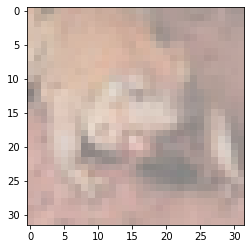

In [14]:
images_batch, labels_batch = next(iter(test_dataloader))
image = images_batch[5]
true_label = labels_batch[5].item()
imshow(image)

In [15]:
ghat = GHat(model)
result = random_attack(ghat, image, true_label, GaussianNoise(mean=0, sigma=0.1))
if result is None:
    print('Attack was not successful')
else:
    label, new_image, attempt = result
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(new_image)

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Attack was not successful


> Как можно видеть, $\hat{g}(x)$ оказался устойчивым к атакам рандомного зашумления. `GaussianNoiser` со стандартным отклонением $\sigma = 0.1$ не поменял класс $\hat{g}$ (было проведено 100 независимых попыток). 

### Атакуем $\hat{g}(x)$ по-умному

Вместо случайной атаки на картинку, будем использовать Монте-Карло оценку градиента $\nabla_x \hat{g}(x)$ вида:

$$
\nabla_x \hat{g}(x) \approx \hat{\nabla}_x \hat{g}(x) = \frac{1}{K} \sum \limits_{i = 1}^{k} \nabla_X \hat{g}_{\text{det}}(x)
$$
$\hat{g}_{\text{det}}(x) = \frac{1}{N} \sum \limits_{i = 1}^N f(x + \varepsilon_i)$, где $\varepsilon_i \sim \mathcal{N}(0,\, \sigma^{2} I)$ зафиксированы заранее (то есть являются константами во время инференса)

Попробуем значения $\epsilon \in \{ 0.4, 0.3, 0.2 \}$

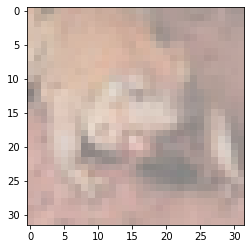

In [16]:
images_batch, labels_batch = next(iter(test_dataloader))
image = images_batch[5]
true_label = labels_batch[5].item()
imshow(image)

Changed class from frog to cat


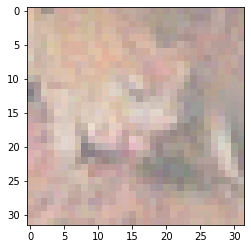

In [17]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model),
    image,
    true_label,
    epsilon=0.04
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

Changed class from frog to cat


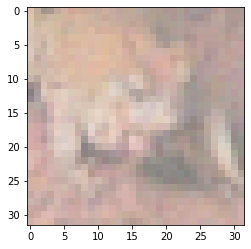

In [18]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model),
    image,
    true_label,
    epsilon=0.03
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Changed class from frog to cat


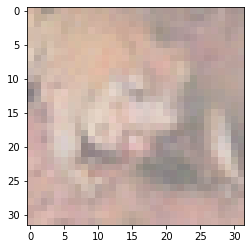

In [24]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model),
    image,
    true_label,
    epsilon=0.02
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

In [37]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model),
    image,
    true_label,
    epsilon=0.016,
    n_samples=5
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

Attack was not successful


In [47]:
model.eval()
epsilon_list = torch.logspace(-3, -1, 30)
ghat = GHat(model)
n_images = 0
ratio_attacks = torch.zeros(epsilon_list.shape[0])
for image_batch, label_batch in tqdm(test_dataloader):
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    for image, label in zip(image_batch, label_batch):
        grad_estimate = get_gradient_estimation(model, image, label, n_samples=2)

        for i, epsilon in enumerate(epsilon_list):
            bad_image = image + epsilon * grad_estimate.sign()
            new_label = ghat(bad_image).argmax().item()
            if new_label != label.item():
                ratio_attacks[i] += 1

        n_images += 1
    if n_images >= 100:
        break
ratio_attacks /= n_images

  0%|          | 0/157 [00:00<?, ?it/s]/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  1%|          | 1/157 [20:37<53:38:04, 1237.72s/it]


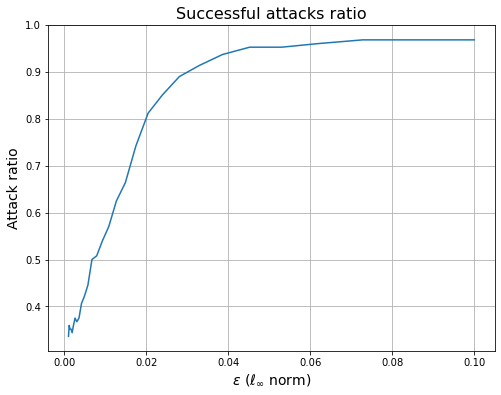

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(epsilon_list, ratio_attacks)
plt.title('Successful attacks ratio', fontsize=16)
plt.xlabel(r'$\varepsilon$ ($\ell_{\infty}$ norm)', fontsize=14)
# plt.xscale('log')
plt.ylabel(r'Attack ratio', fontsize=14)
plt.grid(True)
plt.savefig('graphics/Successful attack ratio (log)', transparent=False, facecolor='white', dpi=1000)

> Атака с помощью оценки градиента $\nabla_X \hat{g}(x)$ оказалась успешной (потребовалась всего 1 попытка, чтобы сломать $\hat{g}(x)$). При этом оказалось достаточным взять $\varepsilon = 0.016$

### Попробуем использовать FGSM атаку на исходный классификатор $f(x)$

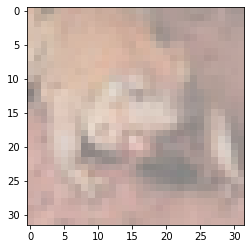

In [22]:
images_batch, labels_batch = next(iter(test_dataloader))
image = images_batch[5]
true_label = labels_batch[5].item()
imshow(image)

Attack worked! Changed class from frog to cat


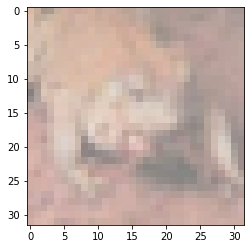

In [23]:
has_attack_worked, bad_image, new_label = fgsm_attack(model, image, true_label, epsilon=1e-2)
if has_attack_worked and model(image.unsqueeze(0).to(device)).argmax() == true_label:
    print(f'Attack worked! Changed class from {classes[true_label]} to {classes[new_label]}')
    imshow(bad_image.cpu())
else:
    print('Attack was not successful')

Attack worked! Changed class from frog to cat


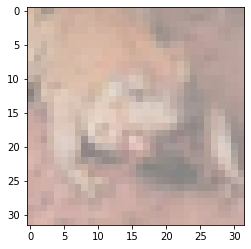

In [24]:
has_attack_worked, bad_image, new_label = fgsm_attack(model, image, true_label, epsilon=0.00355)
if has_attack_worked and model(image.unsqueeze(0).to(device)).argmax() == true_label:
    print(f'Attack worked! Changed class from {classes[true_label]} to {classes[new_label]}')
    imshow(bad_image.cpu())
else:
    print('Attack was not successful')

In [25]:
(bad_image - image.to(device)).norm()

tensor(0.1968, device='cuda:0')

### И ради прикола попробуем атаковать модель $f(x)$ случайным шумом

In [26]:
for _ in range(20):
    result = random_attack(model, image, true_label, GaussianNoise(mean=0, sigma=0.01))
    if result:
        label, new_image, attempt = result
        print(f'Changed class from {classes[true_label]} to {classes[label]}')
        imshow(new_image.cpu())
        break
else:
    print('Attack was not successful')

Attack was not successful


Как можно видеть, случайная атака на $f(x)$ работает довольно плохо.

### Еще эксперименты

Попытка реализовать что-то похожее на метод проекции градиента. Пока не работает

In [27]:
def projE(new_image, image, epsilon=0.2):
    dist = (image - new_image).norm()
    if dist <= epsilon:
        return new_image
    return image + (new_image - image) * epsilon / dist

def projM(new_image, image, epsilon=0.01):
    dist = torch.max(torch.abs(image - new_image))
    if dist <= epsilon:
        return new_image
    return image + (new_image - image) * epsilon / dist

#### Попробуем найти более неуверенную картинку

In [28]:
ghat = GHat(model)
uncertain_image = None
uncertain_label = None
for img, cls in zip(images_batch, labels_batch):
    if ghat(img.to(device).unsqueeze(0)).max() > 0.5 and ghat(img.to(device).unsqueeze(0)).max() < 0.6:
        uncertain_image = img
        uncertain_label = cls
        break

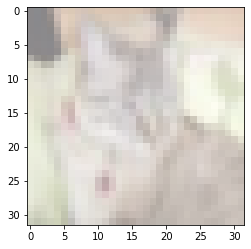

In [29]:
uncertain_image = images_batch[8]
uncertain_label = labels_batch[8]
imshow(uncertain_image)

In [34]:
def get_pa_pb(model, image, confidence=0.9):
    ghat = GHat(model, n_samples=1)
    pa_list = []
    pb_list = []
    for _ in range(1000):
        probs = ghat(image)
        pa = probs.max().item()
        pb = probs[0, probs.sort().indices[0, -2]].item()
        pa_list.append(pa)
        pb_list.append(pb)
    pa_list.sort()
    pb_list.sort()
    pa = pa_list[int(len(pa_list) * (1.0 - confidence))]
    pb = pb_list[int(len(pb_list) * confidence)]
    return pa, pb

def get_radius(model, image, confidence=0.9):
    pa, pb = get_pa_pb(model, image, confidence)
    phi_inv = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
    radius = 0.1 / 2 * (phi_inv(pa) - phi_inv(pb)).item()
    return radius

In [57]:
counts = torch.zeros(10)
ghat = GHat(model, n_samples=1)
for _ in range(1000):
    probs = ghat(uncertain_image)
    counts[probs.argmax().item()] += 1
counts /= 1000
print(counts)
classes[counts.argmax().item()]

tensor([0.0000, 0.0000, 0.0000, 0.2800, 0.5200, 0.0000, 0.1980, 0.0020, 0.0000,
        0.0000])


'deer'

In [59]:
phi_inv = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
0.1 / 2 * (phi_inv(0.5350) - phi_inv(0.2780))

tensor(0.0338)

In [146]:
# is_attack_successful, bad_image, new_label = gradient_estimation_attack(
#     model,
#     GHat(model, n_samples=100),
#     uncertain_image,
#     # uncertain_label,
#     4,
#     epsilon=3e-3
# )

# if is_attack_successful:
#     print(f'Changed class to {classes[new_label]}')
#     imshow(bad_image.squeeze(0).cpu())
# else:
#     print('Attack was not successful')
cur_image = uncertain_image
lr = [0.005 / (_ + 1) for _ in range(20)]
for _ in range(20):
    grad_estimate = get_gradient_estimation(model, cur_image, 4)
    new_image = cur_image + grad_estimate.cpu() * lr[_]
    cur_image = projE(new_image, uncertain_image, epsilon=0.06)
classes[GHat(model, n_samples=100)(cur_image).argmax()]

'deer'

In [144]:
lr = [0.01 / (_ + 1) for _ in range(100)]
for _ in range(10):
    # grad_estimate = get_gradient_estimation(model, cur_image, 4, n_samples=1)
    # new_image = cur_image + grad_estimate.cpu() * lr[_]
    # cur_image = projE(new_image, uncertain_image, epsilon=0.03)
    cat_estimate = get_gradient_estimation(model, cur_image, 3, n_samples=3)
    new_image = cur_image - cat_estimate.cpu() * lr[_]
    cur_image = projE(new_image, uncertain_image, epsilon=0.03)
    new_label = classes[GHat(model, n_samples=100)(cur_image).argmax()]
    if new_label != 'deer':
        print("FOUND!!!")
        print(f'Changed class from deer -> {new_label}')
        break
classes[GHat(model, n_samples=100)(cur_image).argmax()]

KeyboardInterrupt: 

In [147]:
GHat(model, n_samples=100)(cur_image)

tensor([[1.2874e-06, 1.6955e-03, 1.8747e-05, 3.6338e-01, 4.1275e-01, 1.8541e-03,
         2.1770e-01, 2.5542e-03, 1.6455e-05, 2.5779e-05]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [113]:
GHat(model, n_samples=100)(uncertain_image)

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[4.6377e-07, 1.6258e-03, 2.3480e-04, 3.1537e-01, 5.1138e-01, 4.8376e-04,
         1.6984e-01, 1.0510e-03, 7.7975e-06, 1.6059e-05]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [72]:
(0.01 * grad_estimate).norm()

tensor(0.2083, device='cuda:0')

In [68]:
classes[GHat(model, n_samples=100)(uncertain_image).argmax()]

'deer'

In [69]:
classes[GHat(model, n_samples=100)(cur_image).argmax()]

'deer'

In [70]:
(cur_image - uncertain_image).norm()

tensor(0.0300)

In [54]:
(bad_image - uncertain_image.to(device)).norm()

tensor(0.1663, device='cuda:0')

In [37]:
r = get_radius(model, uncertain_image, confidence=0.95)
print(f'{r=}')

r=0.012714335322380067


Проведем рандомную атаку на классификатор:

Changed class from cat to deer
attempt=3


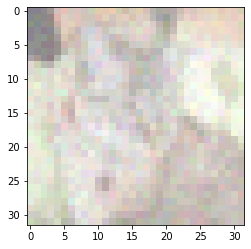

In [77]:
result = random_attack(model, uncertain_image, uncertain_label)
if result is not None:
    new_label, bad_image, attempt = result
    bad_image = bad_image.cpu().squeeze(0)
    print(f'Changed class from {classes[uncertain_label]} to {classes[new_label]}')
    print(f'{attempt=}')
    imshow(bad_image)
else:
    print('Attack was not successful')

In [79]:
uncertain_label

tensor(3)

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Changed class from cat to frog
attempt=20


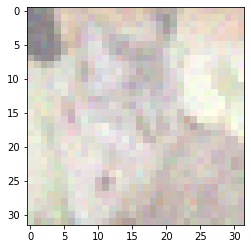

In [83]:
result = random_attack(GHat(model), uncertain_image, uncertain_label)
if result is not None:
    new_label, bad_image, attempt = result
    bad_image = bad_image.cpu().squeeze(0)
    print(f'Changed class from {classes[uncertain_label]} to {classes[new_label]}')
    print(f'{attempt=}')
    imshow(bad_image)
else:
    print('Attack was not successful')

Changed class to deer


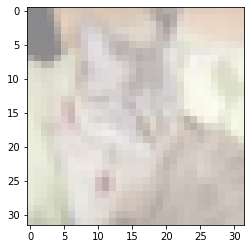

In [84]:
is_attack_successful, bad_image, new_label = gradient_estimation_attack(
    model,
    GHat(model, n_samples=10),
    uncertain_image,
    uncertain_label,
    epsilon=1e-3
)

if is_attack_successful:
    print(f'Changed class to {classes[new_label]}')
    imshow(bad_image.squeeze(0).cpu())
else:
    print('Attack was not successful')

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Changed class to deer


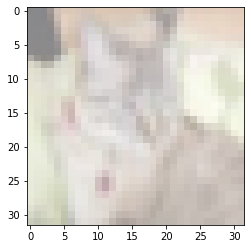

In [91]:
is_attack_successful, bad_image, new_label = gradient_estimation_attack(
    model,
    GHat(model, n_samples=1000),
    uncertain_image,
    uncertain_label,
    epsilon=5e-4
)

if is_attack_successful:
    print(f'Changed class to {classes[new_label]}')
    imshow(bad_image.squeeze(0).cpu())
else:
    print('Attack was not successful')

In [92]:
(bad_image - uncertain_image.to(device)).norm()

tensor(0.0277, device='cuda:0')

In [94]:
r

0.03005315661430359

In [106]:
count_bad = 0
for _ in range(10):
    lbl = classes[GHat(model, n_samples=1000)(uncertain_image).argmax().item()]
    print(f'{lbl=}')
    if lbl != 'cat':
        count_bad += 1
print(f'{count_bad=}')

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
lbl='deer'
count_bad=10


From cat to airplane


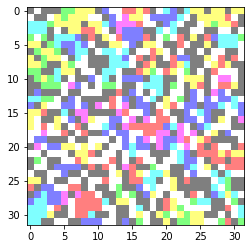

In [165]:
has_attack_worked, bad_image, new_label = fgsm_attack(model, uncertain_image, uncertain_label, epsilon=1)
if has_attack_worked:
    bad_image = bad_image.cpu().squeeze(0)
    print(f'From {classes[uncertain_label]} to {classes[new_label]}')
    imshow(bad_image)
else:
    print('Attack was not successful')

In [149]:
def gen_on_sphere(image, r=0.1):
    new_image = GaussianNoise(mean=0, sigma=0.1)(image)
    dist = (new_image - image).norm()
    return image + (new_image - image) * r / dist

In [150]:
for i in range(len(images_batch)):
    if (images_batch[i] - uncertain_image).norm() < 1e-10:
        print(i)

8


In [179]:
torch.logspace(start=-3, end=-1, steps=20)

tensor([0.0010, 0.0013, 0.0016, 0.0021, 0.0026, 0.0034, 0.0043, 0.0055, 0.0070,
        0.0089, 0.0113, 0.0144, 0.0183, 0.0234, 0.0298, 0.0379, 0.0483, 0.0616,
        0.0785, 0.1000])

In [174]:
count = np.zeros(10)
for _ in range(1000):
    new_image = gen_on_sphere(uncertain_image, 13.0)
    # ghat = GHat(model, sigma=0.1, n_samples=1)
    count[model(new_image.unsqueeze(0).to(device)).argmax()] += 1
count /= 1000
for i in range(10):
    print(f'Prob for {classes[i]}: {count[i]}')

Prob for airplane: 0.251
Prob for automobile: 0.004
Prob for bird: 0.004
Prob for cat: 0.486
Prob for deer: 0.0
Prob for dog: 0.017
Prob for frog: 0.231
Prob for horse: 0.001
Prob for ship: 0.0
Prob for truck: 0.006


In [105]:
classes[model(uncertain_image.to(device).unsqueeze(0)).argmax().item()]

'cat'

In [97]:
get_radius(model, uncertain_image)

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.02463638186454773

In [ ]:
ghat = GHat(model, n_samples=100)
min_pa = 1
max_pb = 0
for _ in range(10):
    probs = ghat(lol_image)
    p_a = probs.max().item()
    p_b = probs[0, probs.sort().indices[0, -2]].item()
    min_pa = min(min_pa, p_a)
    max_pb = max(max_pb, p_b)


PHI_INV = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
R = 0.1 / 2 * (PHI_INV(min_pa) - PHI_INV(max_pb)).item()
print(f'{min_pa=}, {max_pb=}')
print(f'{R=}')

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


min_pa=0.34668654203414917, max_pb=0.3680709898471832
R=-0.002865748107433319


In [ ]:
from tqdm import tqdm

cur_image = image.to(device)
for _ in tqdm(range(50)):
    # step from frog
    grad_estimate = get_gradient_estimation(model, cur_image, true_label, n_samples=1)
    new_image = cur_image + 0.05 * grad_estimate
    cur_image = projE(new_image, image.to(device))
    # step to cat
    cat_grad = get_gradient_estimation(model, cur_image, cat_label, n_samples=1)
    new_image = cur_image - 0.05 * cat_grad
    cur_image = projE(new_image, image.to(device))
    

  0%|          | 0/50 [00:00<?, ?it/s]/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


In [ ]:
ghat = GHat(model)
label = ghat(cur_image).argmax().item()
print(f'Got {classes[label]}')

In [ ]:
from tqdm import tqdm

cur_image = image.to(device)
for _ in tqdm(range(20)):
    # go from frog
    grad_estimate = get_gradient_estimation(model, cur_image, true_label)
    new_image = cur_image + 0.004 * grad_estimate
    cur_image = projE(new_image, image.to(device))
    # go to cat
    cat_grad = get_gradient_estimation(model, cur_image, cat_label, n_samples=1)
    new_image = cur_image - 0.004 * cat_grad
    cur_image = projE(new_image, image.to(device))

  0%|          | 0/20 [00:00<?, ?it/s]/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 20/20 [02:15<00:00,  6.79s/it]


In [ ]:
grad_estimate.norm()

tensor(3.6907, device='cuda:0')

In [ ]:
ghat = GHat(model)
label = ghat(cur_image).argmax().item()
print(f'Got {classes[label]}')

Got frog


In [ ]:
ghat(cur_image)

tensor([[1.0564e-02, 1.1874e-05, 7.6153e-05, 5.6622e-02, 1.6092e-02, 4.1500e-03,
         9.1087e-01, 1.4967e-03, 1.1376e-04, 6.2358e-06]], device='cuda:0',
       grad_fn=<DivBackward0>)

#### Соотношение радиуса устойчивости и атаки

In [ ]:
ghat = GHat(model, n_samples=1000)
min_pa = 1
max_pb = 0
for _ in range(100):
    probs = ghat(image)
    p_a = probs.max().item()
    p_b = probs[0, probs.sort().indices[0, -2]].item()
    min_pa = min(min_pa, p_a)
    max_pb = max(max_pb, p_b)


PHI_INV = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
R = 0.1 / 2 * (PHI_INV(min_pa) - PHI_INV(max_pb)).item()
print(f'{min_pa=}, {max_pb=}')
print(f'{R=}')

/home/user17/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


min_pa=0.9795217514038086, max_pb=0.009462187997996807
R=0.21954939365386963


In [ ]:
PHI_INV(0.999)

tensor(3.0902)

In [ ]:
ghat = GHat(model, n_samples=10000)
probs = ghat(image)
p_a = probs.max().item()
p_b = probs[0, probs.sort().indices[0, -2]].item()

PHI_INV = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
R = 0.1 / 2 * (PHI_INV(p_a) - PHI_INV(p_b)).item()
print(f'{p_a=}, {p_b=}')
print(f'{R=}')

p_a=0.9854736924171448, p_b=0.005442285444587469
R=0.23645772933959963


In [ ]:
ghat = GHat(model, n_samples=50000)
probs = ghat(image)
p_a = probs.max().item()
p_b = probs[0, probs.sort().indices[0, -2]].item()

PHI_INV = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))
R = 0.1 / 2 * (PHI_INV(p_a) - PHI_INV(p_b)).item()
print(f'{p_a=}, {p_b=}')
print(f'{R=}')

p_a=0.9865638613700867, p_b=0.005030582658946514
R=0.23935441970825197


Changed class from frog to cat


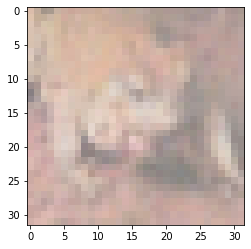

In [ ]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model, n_samples=10000),
    image,
    true_label,
    epsilon=0.02
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

Changed class from frog to cat


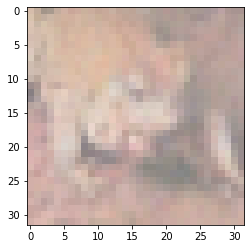

In [ ]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model, n_samples=50000),
    image,
    true_label,
    epsilon=0.02
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

In [ ]:
is_successful, bad_image, label = gradient_estimation_attack(
    model,
    GHat(model, n_samples=100000),
    image,
    true_label,
    epsilon=0.02
)
if is_successful:
    print(f'Changed class from {classes[true_label]} to {classes[label]}')
    imshow(bad_image.cpu())
else:
    print(f'Attack was not successful')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 1.44 MiB is free. Including non-PyTorch memory, this process has 31.73 GiB memory in use. Of the allocated memory 31.30 GiB is allocated by PyTorch, and 50.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Графики

Построим график зависимости точности классификатора $\hat{g}(x)$ в зависимости от параметра $\sigma$

In [17]:
from tqdm import tqdm

sigma_list = torch.logspace(start=-2, end=0, steps=20)
accuracy_list = []
for sigma in sigma_list:
    ghat = GHat(model, sigma=sigma, n_samples=10)
    accuracy = 0.0
    n_images = 0
    for image_batch, label_batch in tqdm(test_dataloader):
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        for image, label in zip(image_batch, label_batch):
            accuracy += (ghat(image).argmax() == label)
            n_images += 1
        if n_images >= 1000:
            break
    accuracy /= n_images
    accuracy_list.append(accuracy)

 10%|▉         | 15/157 [00:30<04:48,  2.03s/it]


In [18]:
accuracy_list = list(map(lambda x: x.item(), accuracy_list))

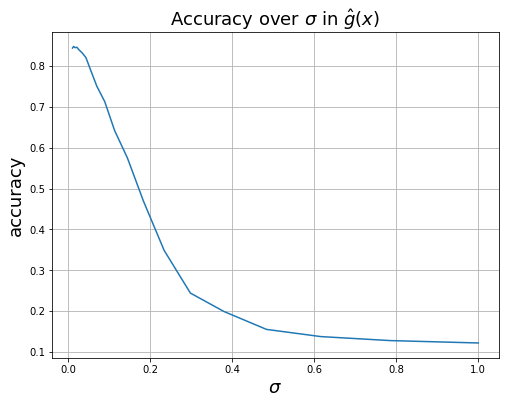

In [97]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_list, accuracy_list)
plt.xlabel(r'$\sigma$', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.title(r'Accuracy over $\sigma$ in $\hat{g}(x)$', fontsize=18)
plt.grid(True)
plt.savefig(r'graphics/sigma over g estimate', transparent=False, facecolor='white', dpi=1000)

In [62]:
image_batch.shape

torch.Size([64, 3, 32, 32])